# Learning Embeddings

> This notebook contains the code for learning embeddings at various stages of the pipeline.

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from collections import defaultdict
from functools import partial
import gc
from operator import itemgetter
from pathlib import Path
from typing import Callable, Dict, List, Optional, Iterable, Protocol, Sequence, Tuple, TypeVar, Type

In [ ]:
#| hide
from fastcore.test import *
import math
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import tempfile
import torch
from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
    SubstringFrequencyAnalysis,
    top_nonzero_tokens
)
from transformer_experiments.common.utils import (
    aggregate_by_string_key,
    DataWrapper,
    topk_across_batches,
)
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.environments import get_environment
from transformer_experiments.models.transformer import (
    block_size,
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer
)
from transformer_experiments.training_utils import CheckPointer, GetBatchFunction, Trainer
from transformer_experiments.experiments.block_internals import (
    BlockInternalsAccessors,
    BlockInternalsExperiment,
    BatchedBlockInternalsExperiment,
    BlockInternalsAnalysis,
    batch_cosine_sim,
)
from transformer_experiments.experiments.cosine_sims import (
    filter_on_prefiltered_results,
    pre_filter_cosine_sim_results,
)
from transformer_experiments.experiments.final_ffwd import FinalFFWDExperiment
from transformer_experiments.experiments.similar_strings import (
    SimilarStringsData,
    SimilarStringsExperiment,
    SimilarStringsResult
)
from transformer_experiments.experiments.logit_lens import LogitLens

In [ ]:
environment = get_environment()
print(f"environment is {environment.name}")

environment is paperspace


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file=environment.code_root / 'nbs/artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9, device=device)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
print(f"device is {device}")

device is cuda


In [ ]:
def learn_embedding_for_char(
    target_char: str,
    embedding_to_logits: Callable[[torch.Tensor], torch.Tensor],
    learning_rate: float = 3e-4,
    max_iters: int = 50000,
    device: str = device,
) -> torch.Tensor:
    """Given a character, learns the embedding that,
    when given as input to the `embedding_to_logits`
    function, produces the logits select that character
    with probability almost 1."""
    assert len(target_char) == 1
    target = torch.tensor(tokenizer.encode(target_char), device=device)

    lsfm = nn.LogSoftmax(dim=-1)
    lsfm.to(device)

    x = torch.nn.Parameter(torch.randn(1, 1, n_embed, device=device), requires_grad=True)

    optimizer = torch.optim.AdamW([x], lr=learning_rate)
    eval_iters = max_iters // 10

    print(f"Optimizing embedding for {repr(target_char)}")
    for step in range(max_iters):

        logits = embedding_to_logits(x)
        B, T, C = logits.shape

        yhat = lsfm(logits.view(B * T, C))
        loss = F.nll_loss(yhat, target)

        if torch.isclose(loss, torch.tensor(0, dtype=loss.dtype, device=device)).item():
            print(f"ending training at step {step:>5}: loss {loss.item():.6f}")
            break

        if step % eval_iters == 0:
            print(f"step {step:>5}: loss {loss.item():.6f}")

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return x.data.detach(), loss

In [ ]:
def transformer_output_head_function(m: TransformerLanguageModel) -> Callable[[torch.Tensor], torch.Tensor]:
    ln_f = nn.LayerNorm(n_embed)
    lm_head = nn.Linear(n_embed, tokenizer.vocab_size)

    ln_f.load_state_dict(m.ln_f.state_dict())
    lm_head.load_state_dict(m.lm_head.state_dict())

    ln_f.to(device)
    lm_head.to(device)

    return lambda x: lm_head(ln_f(x))


In [ ]:
torch.manual_seed(42)
emb_a, _ = learn_embedding_for_char('a', transformer_output_head_function(m))

Optimizing embedding for 'a'
step     0: loss 2.809722
step  5000: loss 0.009828
step 10000: loss 0.000751
step 15000: loss 0.000073
step 20000: loss 0.000008
step 25000: loss 0.000001
step 30000: loss 0.000000
step 35000: loss 0.000000
step 40000: loss 0.000000
step 45000: loss 0.000000


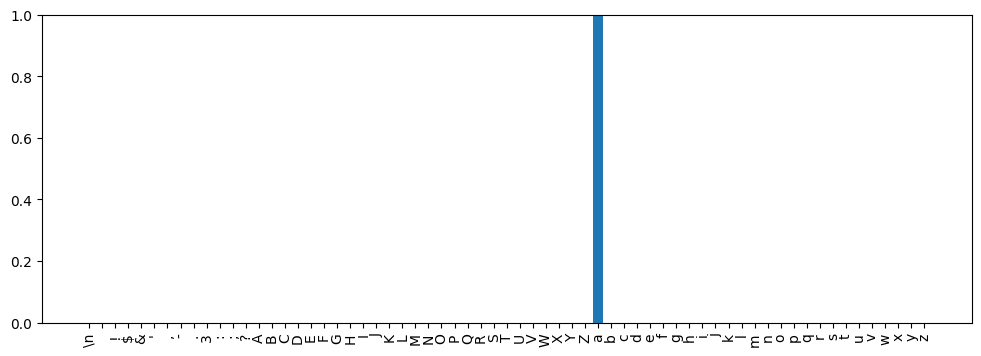

In [ ]:
logits = LogitsWrapper(accessors.logits_from_embedding(unsqueeze_emb(emb_a)), tokenizer)
logits.plot_probs()

In [ ]:
def block_n_on_function(m: TransformerLanguageModel, n: int) -> Callable[[torch.Tensor], torch.Tensor]:
    assert n >= 0 and n < n_layer, "n must be in [0, n_layer)"

    blocks, _ = zip(
        *[
            accessors.copy_block_from_model(block_idx=i)
            for i in range(n, n_layer)
        ]
    )
    blocks_module = torch.nn.Sequential(*blocks)
    output_head = transformer_output_head_function(m)
    return lambda x: output_head(blocks_module(x))

In [ ]:
torch.manual_seed(42)
emb_a, _ = learn_embedding_for_char('a', block_n_on_function(m, n=5))

Optimizing embedding for 'a'
step     0: loss 6.885742
step  5000: loss 0.006737
step 10000: loss 0.000552
step 15000: loss 0.000055
step 20000: loss 0.000009
step 25000: loss 0.000002
step 30000: loss 0.000001
step 35000: loss 0.000000
step 40000: loss 0.000000
step 45000: loss 0.000000


In [ ]:
torch.manual_seed(42)
emb_a, _ = learn_embedding_for_char('a', block_n_on_function(m, n=1))